<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Interactive Model Fitting

### Michael J. Pyrcz, Professor, The University of Texas at Austin 

*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

#### Fitting a Model

There are two common methods to fit a model, ordinary least squares and maximim likelihood estimation. Here I provide a short description and then demonstrate them together for fitting a parametric Gaussian distribution to a synthetic data set.

First, let's define the model and data.

* The model parameters, $\beta$, are trained to the training data, $X_{\alpha}, \alpha = 1,\ldots,n$.
* In this example the model is a parametric Gaussian distribution; therefore the model parameters are the mean, $\mu$, and standard deviation, $\sigma$.
* For this example, the synthetic data are a limited set of independent samples from an 'unknown' Gaussian distributions; therefore, we expect that our model selection should be reasonable, i.e., the data is somewhat Gaussian distributed.

##### Ordinary Least Squares Fitting

This is a very common method for fitting a model, let's minimize the error between the model predictions and the observations. 

* We calculated the model predictions, $\hat{y}_{\alpha}$, at training data locations, $\alpha = 1,\ldots,n$.  
* Then we compare the model predictions to the true data observations as the squared error, $\Delta y_{\alpha}^2 = \left(\hat{y}_{\alpha} - y_{\alpha} \right)^2$, where the model predictions, $\hat{y}_{\alpha} = \hat{f}_{\beta}(X_{\alpha})$, are estimated with our estimated model parameters, $\hat{f}_{\beta}(X_{\alpha})$.
* We then sum the squared error over all data observations, the sum of squared error (SSE) is $\sum_{\alpha=1}^n \left(\hat{y}_{\alpha} - y_{\alpha} \right)^2$

Now we pose the model parameter estimation problem as an optimization problem to select the model parameters such that we minimize the SSE.

\begin{equation}
\hat{\beta}^{OLS}= {\text{arg min}}_{\beta} \rightarrow \left(\hat{f}_{\beta}(X_{\alpha}) - y_{\alpha} \right)^2
\end{equation}

##### Maximum Likelihood Fitting

This is a different way to approach fitting a model, find the model parameters, $\beta$, that maximizes the probability of the sample data, $X$. 

For the Bayesian approach to machine learning, this is the **likelihood** that is applied to the **prior** to calculate the **posterior**. Under the assumption of data independence we apply the product sum to the probability of each of the data, $X_\alpha = 1,\ldots,n$, given the model:

\begin{equation}
P(X | \hat{f}_{\beta}) = \prod_{\alpha = 1}^{n} P(X_{\alpha}|\hat{f}_{\beta}(X)), \alpha = 1,\ldots,n
\end{equation}

For our maximization it is sufficient to work with likelihoods, the density values directly from the PDF model, $\hat{f}_{\beta}(X_{\alpha})$.

\begin{equation}
P(X | \hat{f}_{\beta}) = \prod_{\alpha = 1}^{n} \hat{f}_{\beta}(X_{\alpha}), \alpha = 1,\ldots,n
\end{equation}

This solution can be very small given a large number of sample data, so we commonly apply the log transform to work with the sum of the log likelihoods and we calculate the negative sum of log likelihoods to convert this to a standard minimization problem.

\begin{equation}
P(X | \hat{f}_{\beta}(X)) = -\sum_{\alpha = 1}^{n} log \left(\hat{f}_{\beta}(X_{\alpha})\right), \alpha = 1,\ldots,n
\end{equation}

Now we pose the model parameter estimation problem as an optimization problem to select the model parameters such that we minimize the negative log likelihood.

\begin{equation}
\hat{\beta}^{OLS}= {\text{arg min}}_{\beta} \rightarrow P(X | \hat{f}_{\beta}(X))
\end{equation}

#### Load and Configure the Required Libraries

The following code loads the required libraries and sets a plotting default.

In [1]:
%matplotlib inline
seed=73073                                              
supress_warnings = False
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import norm                            # Gaussian PDF
import matplotlib.pyplot as plt                         # plotting
import seaborn as sns                                   # plot PDF
from sklearn.model_selection import train_test_split    # train and test split
from sklearn import tree                                # tree program from scikit learn (package for machine learning)
from sklearn import metrics                             # measures to check our models
import scipy.stats as stats                             #search for neighbours
from matplotlib.patches import Rectangle                # build a custom legend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import math                                             # sqrt operator
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
cmap = plt.cm.inferno                                   # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                          # grid behind plotting elements
if supress_warnings == True:
    import warnings                                     # supress any warnings for this demonstration
    warnings.filterwarnings('ignore')                  

#### Declare Functions

The following functions for clean code. 

* Just a improved grid for the plot.

* Gaussian negative log likelihood function modified from [StackExchange](https://stats.stackexchange.com/questions/504004/how-do-we-code-a-maximum-likelihood-fitting-for-a-simple-gaussian-data) solution from jkpate.

In [2]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
    
def gaussian_negloglike(params):    # Calculate sum negative log likelihood
    mu = params[0]; sigma = params[1]
    neg_log_likelihood = -1*np.sum(stats.norm.logpdf(X, loc=mu, scale=sigma)) 
    return neg_log_likelihood

#### Make and Display a Synthetic Dataset

We draw random samples from a a parametric Gaussian distritubion and visualize the data-derived nonparametric and the Gaussian parametric CDF, fit with: 

* OLS - ordinary least squares

* MLE - maximum likelihood estimation 

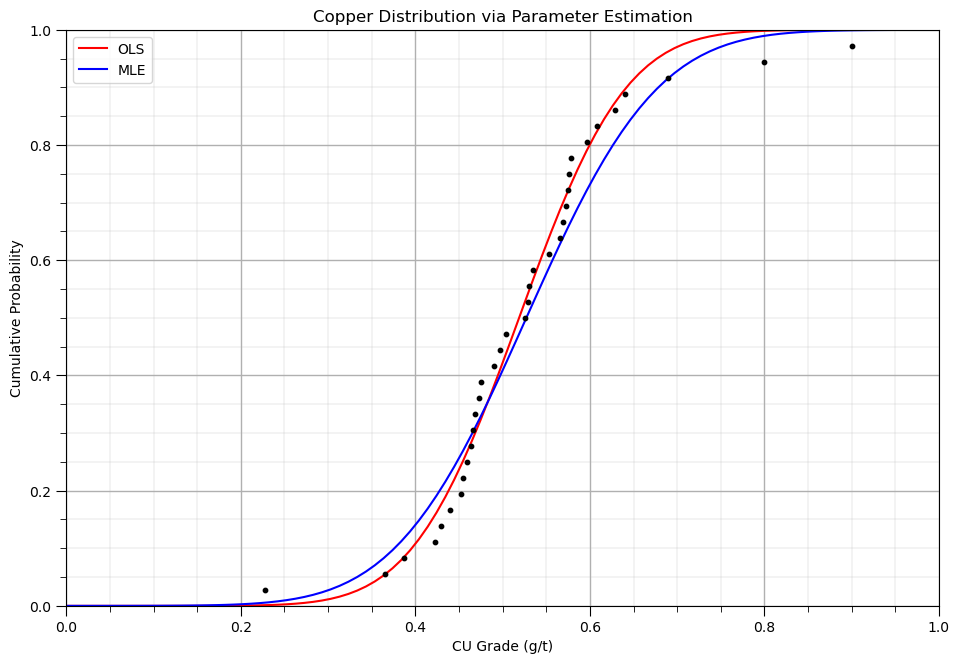

In [3]:
n = 35; tmean = 0.5; tstdev = 0.1; xmin=0.0; xmax=1.0
np.random.seed(seed=seed)                               # set random number seed
Xval = np.linspace(xmin,xmax,100)
X = np.random.normal(loc=tmean,scale=tstdev,size=n-2); X = np.append(X,[0.8,0.9])
X = np.sort(X); CDF = np.arange(1,n+1,1)/(n+1)

mean = np.average(X); stdev = np.std(X)

mean_ls,stdev_ls = curve_fit(norm.cdf,X,CDF,p0=[0,1],method='lm')[0] 

mean_ml,stdev_ml = minimize(gaussian_negloglike,x0=[0,1],method='Nelder-Mead').x

plt.subplot(121)
plt.scatter(np.sort(X),np.arange(1,n+1,1)/(n+1),c='black',s=10,edgecolor='black',zorder=10)
plt.title('Copper Distribution via Parameter Estimation')
# plt.plot(Xval,stats.norm.cdf(Xval,loc=mean,scale=stdev),c='black',zorder=1,label='Parameter Inference')
plt.plot(Xval,stats.norm.cdf(Xval,loc=mean_ls,scale=stdev_ls),c='red',zorder=1,label='OLS')
plt.plot(Xval,stats.norm.cdf(Xval,loc=mean_ml,scale=stdev_ml),c='blue',zorder=1,label='MLE')

plt.legend(loc='upper left')
plt.ylim([0,1]); plt.xlim([0,1.0]); add_grid(); plt.xlabel('CU Grade (g/t)'); plt.ylabel('Cumulative Probability')

plt.subplots_adjust(left=0.0,bottom=0.0,right=3.0,top=1.2); plt.show() # set plot size 

#### Make the Interactive Dashboard

Change the mean and standard deviation of a Gaussian model and observe the ordinary least squares and maximum likelihood assessment of fit.

In [5]:
l = widgets.Text(value='                                  Interactive Statistical Model Fitting Demo, Prof. Michael Pyrcz, The University of Texas at Austin',
                 layout=Layout(width='750px', height='30px'))

mean = widgets.FloatSlider(min=0.0, max = 1.0, value=0.5, step = 0.02, description = '$\mu$',orientation='horizontal', 
           style = {'description_width': 'initial'},layout=Layout(width='370px', height='30px'),continuous_update=False)
stdev = widgets.FloatSlider(min=0.01, max = 1.0, value=0.1, step = 0.02, description = r'$\sigma$',orientation='horizontal',
           style = {'description_width': 'initial'},layout=Layout(width='370px', height='30px'),continuous_update=False)

ui = widgets.HBox([mean,stdev],)
ui2 = widgets.VBox([l,ui],)

def run_plot(mean,stdev):
    np.random.seed(seed=seed)                               # set random number seed
    Xval = np.linspace(xmin,xmax,100)
    
    CDF_hat = norm.cdf(X,loc = mean,scale=stdev)            # for specified mean and stdev calculate the PDF and CDF
    pdf_hat = stats.norm.pdf(X,loc=mean,scale=stdev)
    sq_err = (CDF-CDF_hat)**2                               # calculate the square error of the CDF
    sse = np.sum(sq_err)
    prod_like = np.product(pdf_hat)                         # calculate the likelihoof from the PDF
    neg_log_like = -np.sum(np.log(pdf_hat))
    
    mean_OLS,stdev_OLS = curve_fit(norm.cdf,np.sort(X),np.arange(1,n+1,1)/(n+1), p0=[0,1],method='lm')[0] # calculate OLS and error
    sq_err_OLS = (CDF-norm.cdf(X,loc = mean_OLS,scale=stdev_OLS))**2
    sse_OLS = np.sum(sq_err_OLS)
    
    mean_MLE,stdev_MLE = minimize(gaussian_negloglike,x0=[0,1],method='Nelder-Mead').x # calculate MLE and likelihood
    pdf_hat_MLE = stats.norm.pdf(X,loc=mean_MLE,scale=stdev_MLE)
    prod_like_MLE = np.product(pdf_hat_MLE) 
    neg_log_like_MLE = -np.sum(np.log(pdf_hat_MLE))
    
    plt.subplot(221)                                         # plot CDF and errors and OLS solution
    plt.scatter(np.sort(X),np.arange(1,n+1,1)/(n+1),c='black',s=10,edgecolor='black',zorder=10)
    plt.title('Ordinary Least Squares - Model and Data Error')
    plt.plot(Xval,stats.norm.cdf(Xval,loc=mean,scale=stdev),c='red',lw=3,label=r'$\hat{F}_{Cu}(\alpha)$',zorder=100)
    plt.plot(Xval,stats.norm.cdf(Xval,loc=mean_OLS,scale=stdev_OLS),c='grey',alpha=0.3,lw=3,label=r'$\hat{F}_{Cu}^{OLS}(\alpha)$',zorder=10)
    for i in range(0,len(X)):
        plt.plot([X[i],X[i]],[CDF[i],CDF_hat[i]],color='black',alpha=0.3,zorder=1)
    plt.legend(loc='upper left')
    plt.ylim([0,1]); plt.xlim([0,1.0]); add_grid(); plt.xlabel('Copper Grade (g/t)'); plt.ylabel(r'Cumulative Probability, $F_{Cu}$')
    plt.annotate(r'Current Model: $\mu = $' + str(np.round(mean,2)),xy=[0.68,0.4],c='red')
    plt.annotate(r'$\sigma = $' + str(np.round(stdev,2)),xy=[0.80,0.35],c='red')
    plt.annotate(r'OLS Solution: $\mu = $' + str(np.round(mean_OLS,2)),xy=[0.69,0.3],c='black')
    plt.annotate(r'$\sigma = $' + str(np.round(stdev_OLS,2)),xy=[0.80,0.25],c='black')
    
    plt.subplot(222)                                         # plot error distribution and OLS solution
    plt.hist(sq_err,color='red',alpha=0.6,edgecolor='darkred',lw=2,bins=np.linspace(0.0,0.1,41),zorder=10)
    plt.hist(sq_err_OLS,color='grey',alpha=1.0,edgecolor='black',lw=2,bins=np.linspace(0.0,0.1,41),zorder=1)
    plt.xlabel(r'Squared Error, $\left( \hat{F}_{Cu}(\alpha) - F_{Cu}(\alpha) \right)^2$'); plt.ylabel('Frequency'); plt.title('Ordinary Least Squares - Data Error Distribution')
    add_grid(); plt.xlim([0.0,0.1]); plt.ylim([0,30])
    plt.annotate(r'Minimize: $\sum_{\alpha=1}^n \left( \hat{F}_{Cu}(\alpha) - F_{Cu}(\alpha) \right)^2 = $' + str(np.round(sse,2)),xy=[0.065,25.0],c='red')
    plt.annotate(r'OLS: $\sum_{\alpha=1}^n \left( \hat{F}_{Cu}^{OLS}(\alpha) - F_{Cu}(\alpha) \right)^2 = $' + str(np.round(sse_OLS,2)),xy=[0.069,22.0],c='black')
    
    plt.subplot(223)                                         # plot data likelihood, PDF and MLE solution
    plt.scatter(np.sort(X),np.full(len(X),0.03),c='black',s=10,edgecolor='black',zorder=10)
    plt.title('Copper Distribution via Parameter Estimation')
    plt.plot(Xval,stats.norm.pdf(Xval,loc=mean,scale=stdev),c='blue',lw=3,label=r'$\hat{f}_{Cu}(\alpha)$',zorder=100)
    plt.plot(Xval,stats.norm.pdf(Xval,loc=mean_MLE,scale=stdev_MLE),c='grey',alpha=0.3,lw=3,label=r'$\hat{f}_{Cu}^{MLE}(\alpha)$',zorder=10)
    for i in range(0,len(X)):
        plt.plot([X[i],X[i]],[0.0,pdf_hat[i]],color='black',alpha=0.3,zorder=1)
    plt.annotate(r'Current Model: $\mu = $' + str(np.round(mean,2)),xy=[0.68,3.5],c='blue')
    plt.annotate(r'$\sigma = $' + str(np.round(stdev,2)),xy=[0.80,3.3],c='blue')
    plt.annotate(r'MLE Solution: $\mu = $' + str(np.round(mean_MLE,2)),xy=[0.69,3.1],c='black')
    plt.annotate(r'$\sigma = $' + str(np.round(stdev_MLE,2)),xy=[0.80,2.9],c='black')
    plt.xlabel('Copper Grade (g/t)'); plt.ylabel(r'Likelihood, Density, $f_{Cu}$'); plt.title('Maximum Likelihood - Model and Data Likelihood')
    add_grid(); plt.xlim([0.0,1.0]); plt.ylim([0.0,4.0]); plt.legend(loc='upper left')
    
    plt.subplot(224)                                          # plot data likelihood distribution and MLS solution
    plt.hist(pdf_hat,color='blue',alpha=0.5,edgecolor='darkblue',lw=2,bins=np.linspace(0.0,4.0,41),orientation='horizontal',zorder=100)
    plt.hist(pdf_hat_MLE,color='grey',alpha=1.0,edgecolor='black',lw=2,bins=np.linspace(0.0,4.0,41),orientation='horizontal',zorder=10)
    plt.xlabel('Frequency'); plt.ylabel(r'Likelihood, Density, $f_{Cu}$'); plt.title('Maximum Likelihood - Data Likelihood Distribution')
    add_grid(); plt.xlim([0.0,10.0]); plt.ylim([0.0,4.0])
    plt.annotate(r'Maximize: $\prod_{\alpha=1}^n \hat{f}_\alpha = $' + str(np.round(prod_like,2)),xy=[6.5,3.5],c='blue')
    plt.annotate(r'MLE: $\prod_{\alpha=1}^n \hat{f}_{Cu}^{MLE}(\alpha) = $' + str(np.round(prod_like_MLE,2)),xy=[6.9,3.1],c='black')
    plt.annotate(r'Minimize: $-\sum_{\alpha=1}^n log\left[ \hat{f}_{Cu}(\alpha) \right]  = $' + str(np.round(neg_log_like,2)),xy=[6.5,2.7],c='blue')
    plt.annotate(r'MLE: $-\sum_{\alpha=1}^n \left( log(\hat{f}_{Cu}^{MLE}(\alpha) )   \right)  = $' + str(np.round(neg_log_like_MLE,2)),xy=[6.9,2.3],c='black')
     
    plt.subplots_adjust(left=0.0,bottom=0.0,right=3.0,top=2.2); plt.show() # set plot size 
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(run_plot, {'mean':mean,'stdev':stdev})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating  

### Interactive Statistical Model Fitting Demonstation 

#### Michael Pyrcz, Professor, The University of Texas at Austin 

Change the mean and standard deviation of a Gaussian model and observe the ordinary least squares and maximum likelihood assessment of fit.

### The Inputs

* Gaussian Parametric Model: **$\mu$** - mean, **$\sigma$** - standard deviation

In [6]:
display(ui2, interactive_plot)                           # display the interactive plot

Output()

#### Comments

This was a basic demonstration of squared error and data likelihood for OLS and MLE model fitting respectively. I have many other demonstrations and even basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
#### The Author:

### Michael J. Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  